# Simplex Airfoils

Many indoor models are constructed using a simple circular arc airfoil. I showed how to use the Python **sympy** package to figure out the radius needed for some specified camber in my last article{cite}`black2021`.

The circular arc has its high point at the 50% chord point, which does not look much like a traditional airfoil. Another popular shape is called the *Simplex* airfoil, which moves the high point forward to about the 36% chord point. *Simplex* airfoils are unique in that one template can be used for any chord width by pinning the leading edge and rotating the template to match the desired chord. A bit of digging on the Internet turned up an Excel spreadsheet {cite}`simplex` that contained the code needed to generate the airfoil shape, but I want to be able to generate these shapes directly in Python. Let's extract the formulas needed from the spreadsheet and see what we get:

## Simplex Airfoil Spreadsheet Formulas

The formulas from the spreadsheet are these:

\begin{equation}
\alpha = 1.554\ camber\ \pi/180
\end{equation}

Here **camber** is the percentage of the chord desired.

\begin{equation}
\psi = \pi \tan(\alpha)ln(x)
\end{equation}

Where $x$ is a number ranging from $0$ to $1$. This is not the same as the $x$ coordinate we use for the airfoil.

\begin{equation}
\rho = {\rm e}^{\psi/\tan(\alpha)}
\end{equation}

\begin{equation}
x = \rho \sin{\psi}
\end{equation}

\begin{equation}
y = \rho \cos({-\psi})
\end{equation}

These equations work in generating the airfoil shape. However, I prefer to use verifiable equations that I can prove are correct, so we will explore generating the airfoil using **sympy** below.

For now, let's explore an example airfoil.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [33]:
chord = 2
camber = 10
npoints = 26
alpha = 1.554 * camber * math.pi/180
k = 1/math.tan(alpha)
print(alpha, k)

0.2712241657599188 3.5961325376417776


In [34]:
roa = np.linspace(0,1,npoints)
roa[0] = 0.0000001  # avoid infinity in ln(0)
psi = np.pi * np.tan(alpha/2) * np.log(roa)

In [35]:
rho = chord * np.exp(psi / np.tan(alpha))
#rho[0] = 0
xc = rho * np.cos(psi)
yc = rho * np.sin(-psi)
print("  psi    rho     x      y")
for i in range(npoints):
    print("%6.3f %6.3f %6.3f %6.3f" % (psi[i], rho[i], xc[i], yc[i]))
    #print(psi[i], rho[i], xc[i], yc[i])

  psi    rho     x      y
-6.909  0.000  0.000  0.000
-1.380  0.014  0.003  0.014
-1.083  0.041  0.019  0.036
-0.909  0.076  0.047  0.060
-0.786  0.119  0.084  0.084
-0.690  0.167  0.129  0.106
-0.612  0.222  0.181  0.127
-0.546  0.281  0.240  0.146
-0.488  0.345  0.305  0.162
-0.438  0.414  0.375  0.176
-0.393  0.487  0.450  0.186
-0.352  0.564  0.530  0.194
-0.315  0.645  0.613  0.200
-0.280  0.730  0.701  0.202
-0.249  0.818  0.793  0.201
-0.219  0.910  0.888  0.198
-0.191  1.005  0.987  0.191
-0.165  1.104  1.089  0.182
-0.141  1.205  1.193  0.169
-0.118  1.310  1.301  0.154
-0.096  1.418  1.411  0.135
-0.075  1.529  1.524  0.114
-0.055  1.642  1.640  0.090
-0.036  1.759  1.758  0.063
-0.017  1.878  1.878  0.033
 0.000  2.000  2.000 -0.000


This looks exactly like the output from the spreadsheet. I used a hack to keep $r/a$ from reaching zero, which would have sent $ln(0r/a$ to infinity! There is still a "magic" number here that converts camber to the initial slope of the arc. I will try to figure that out later!

Let's get a look at this airfoil:

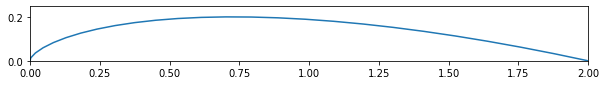

In [37]:
plt.figure(figsize=(10,1))
plt.xlim(0, 2)
plt.ylim(0, 0.25)
plt.plot(xc,yc)
plt.show()

In [38]:
mm = max(yc)
mmi = np.where(yc==mm)
print("Camber",max(yc),"at",xc[mmi][0])

Camber 0.2019217679605224 at 0.7013640792137934


It looks like this code will generate our airfoil shape. In order to generate aerodynamic coefficient data for this airfoil, we need to set up procedures that will return the camber line for this airfoil so it can be used by the airfoil generator code we will use to set up **xfoil** analysis.

Here is the procedure we will use:

In [39]:
def simplex_camber_line(camber, npoints):
    """return list of points on camber line. camber is in percentage"""
    alpha = 1.554 * camber * math.pi/180 # radians
    k = 1/math.tan(alpha)
    
    # generate airfoil points
    roa = np.linspace(0,1,npoints)
    roa[0] = 0.0000001  # avoid infinity in ln(0)
    psi = np.pi * np.tan(alpha/2) * np.log(roa)
    rho = 1.0 * np.exp(psi / np.tan(alpha))
    x = rho * np.cos(psi)
    y = rho * np.sin(-psi)
    return x,y

Now, we can create the wing airfoil camber line for the *Wart*:

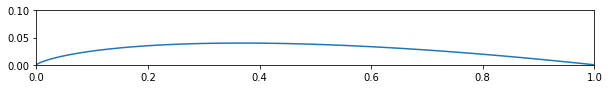

In [41]:
xc, yc = simplex_camber_line(4,51)    
plt.figure(figsize=(10,1))
plt.xlim(0, 1)
plt.ylim(0, 0.1)
plt.plot(xc,yc)
plt.show()

## Simplex Airfoil Function

Now that we have the camber line defined, we will build an airfoil section following the development we used for the circular arc.

In [59]:
def slope(xc,yc):
    mc = []
    for i in range(1,len(xc)):
        dx = xc[i] - xc[i-1]
        mc.append((yc[i] - yc[i-1])/dx)
    dx = xc[-1]-xc[-2]
    mc.append((yc[-1] - yc[-2])/dx)
    return mc

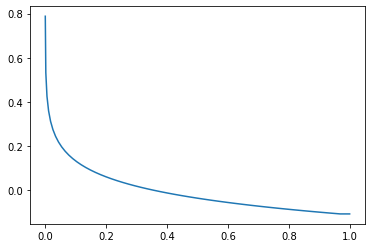

In [60]:
mc = slope(xc,yc)
plt.plot(xc,mc)
plt.show()

In [61]:

def getLE(x0,y0,alpha):
    r0 = 0.005 # 1% thickness
    x = []
    y = []
    angles = np.linspace(np.pi/2 + alpha, 3*math.pi/2 + alpha, 19)
    for i in range(len(angles)):
        x.append(x0 + r0 * math.cos(angles[i]))
        y.append(y0 + r0 * math.sin(angles[i]))
    return x,y

In [71]:
mc

[0.7879056680656382,
 0.5323856971586532,
 0.4255962657435849,
 0.3594355921172993,
 0.3117670052352285,
 0.274607841396815,
 0.24420164948392062,
 0.21848948231593104,
 0.19622397358276752,
 0.17659371081599531,
 0.15904197282862373,
 0.1431706080969679,
 0.1286852497882845,
 0.11536225583848539,
 0.10302781139525669,
 0.0915442007998646,
 0.08080049171471079,
 0.07070603528424733,
 0.061185820750289326,
 0.05217708492754307,
 0.04362679128230008,
 0.035489724464120305,
 0.02772702866754232,
 0.020305071487976566,
 0.013194550135076576,
 0.006369780599288847,
 -0.00019187333226835252,
 -0.006510462928218539,
 -0.01260383287422411,
 -0.018487932972816548,
 -0.024177076775926176,
 -0.029684157619948092,
 -0.03502083020262864,
 -0.04019766408463691,
 -0.04522427416206292,
 -0.05010943212978349,
 -0.05486116216097836,
 -0.05948682340783006,
 -0.06399318144074748,
 -0.06838647035734711,
 -0.07267244698463265,
 -0.07685643835096467,
 -0.08094338340531408,
 -0.08493786979967156,
 -0.08884416

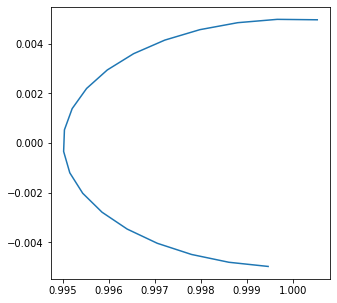

In [65]:
xl,yl = getLE(xc[-1], yc[-1], mc[-1])
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(5)
#plt.plot(xc,mc)
plt.plot(xl,yl)
#plt.plot(xp,yp)
#plt.plot(xa[100:],ya[100:])
#plt.plot([0,0.02],[0.0,0.0])
#plt.ylim(top=0.02, bottom = -0.02)
#plt.xlim(left=-0.02,right=0.02)
plt.show()
#print(ma[-1])

In [44]:
def simplexCamber(x,y,m, thickness):
    xu = []
    yu = []
    xl = []
    yl = []
    for i in range(len(x)):
        xp = x[i]
        yp = y[i]
        angle = math.atan(m[i])
        xu.append(xp - thickness * math.sin(angle))
        yu.append(yp + thickness * math.cos(angle))
        xl.append(xp + thickness * math.sin(angle))
        yl.append(yp - thickness * math.cos(angle))
    return xu,yu,xl,yl

In [45]:
xu,yu,xl,yl = simplexCamber(xa,ya,ma,0.005)
f = plt.figure()
f.set_figwidth(11)
f.set_figheight(2)
plt.ylim(top=0.15, bottom = -0.05)
plt.xlim(left=-0.05,right=1.05)
plt.plot(xu,yu)
plt.plot(xl,yl)
plt.plot(xp,yp)
plt.show()

NameError: name 'xa' is not defined

In [26]:
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(5)
plt.plot(xa,ya)
plt.plot(xp,yp)
plt.plot(xu,yu)
plt.plot(xl,yl)
plt.plot(xa[100:],ya[100:])
plt.plot([0,0.02],[0.0,0.0])
plt.ylim(top=0.02, bottom = -0.02)
plt.xlim(left=-0.02,right=0.02)
plt.show()

NameError: name 'xa' is not defined

<Figure size 360x360 with 0 Axes>

In [27]:
def getTE(xp, yp, mp, thickness):
    nx = len(xc)
    t = thickness/100
    r = t/2
    # set trailing edce distribution
    aa = r/25 - r
    cc = r
    xtopte = []
    ytopte = []
    xbotte = []
    ybotte = []

    for i in range(5+1):
        j = nx - 5 + i
        xx = i*0.2
        tt = aa*xx**2 + cc
        alpha = math.atan(mp[j]) + math.pi/2
        xc = xp[j]
        yc = yp[j]
        xt = xc + tt * math.cos(alpha)
        yt = yc + tt * math.sin(alpha)
        xtopte.append(xt)
        ytopte.append(yt)
        alpha += math.pi
        xb = xc + tt * math.cos(alpha)
        yb = yc + tt * math.sin(alpha)
        xbotte.append(xb)
        ybotte.append(yb)
    return xtopte, ytopte, xbotte, ybotte


